In [1]:
import pandas as pd
import gurobipy
import numpy as np

In [2]:
from utils import explain_one_to_one, weighted_sum_ranking

# RATP

Notre objectif est d’expliquer la sélection du meilleur projet, puis des 3 meilleurs, puis des 5 meilleurs. Nous souhaitons justifier ce choix à l’aide de comparaisons par paires. Il faut donc réfléchir à une manière intelligente de choisir les paires à comparer, puis exécuter successivement les algorithmes (1-1, 1-m, m-1, m-m).

### Charger le dataset


In [3]:
ratp_df = pd.read_excel('datasets/RATP.xlsx')
ratp_df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Metro station,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]"
2,NaN,Odéon (Ligne 4),85000,8100,35500,3450,75,16.2,88
3,NaN,Place d'Italie (Lign 6),81000,8100,37500,3150,67,17.6,95
4,NaN,Jussieu (Ligne 7),74000,8900,37000,4050,68,16.8,79
5,NaN,Nation (Ligne 9),74000,7100,42000,4550,77,15.2,73
6,NaN,La Motte Picquet-Grenelle (Ligne 10),72000,7500,33000,4250,88,13.2,93
7,NaN,Porte d'Orléans (Ligne 4),71000,7300,31500,4600,76,15.8,93
8,NaN,Daumenil (Ligne 6),79000,6900,39000,3800,67,16.8,79
9,NaN,Vaugirard (Ligne 12),57000,7600,40500,3800,82,17.2,77


In [4]:
#Supprimer la première colonne 
ratp_df = ratp_df.iloc[:, 1:]

# Mettre la ligne 1 comme header
ratp_df.columns = ratp_df.iloc[1]
ratp_df = ratp_df.drop(index=1)

# Extraire la ligne weights comme vecteur
weights_row = ratp_df.iloc[12, :]


# Vecteur numpy
weights = weights_row.iloc[1:].astype(float).to_numpy()

#  Série pandas avec labels
weights_series = weights_row.iloc[1:].astype(float)
weights_series.index = ratp_df.columns[1:]

# Supprimer les lignes vides (0, 12, la ligne weights)
ratp_df = ratp_df[~ratp_df.iloc[:, 0].isna()]
ratp_df = ratp_df[
    ratp_df.iloc[:, 0].astype(str).str.strip() != "weights"
]


In [5]:
ratp_df

1,Metro station,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]"
2,Odéon (Ligne 4),85000,8100,35500,3450,75,16.2,88
3,Place d'Italie (Lign 6),81000,8100,37500,3150,67,17.6,95
4,Jussieu (Ligne 7),74000,8900,37000,4050,68,16.8,79
5,Nation (Ligne 9),74000,7100,42000,4550,77,15.2,73
6,La Motte Picquet-Grenelle (Ligne 10),72000,7500,33000,4250,88,13.2,93
7,Porte d'Orléans (Ligne 4),71000,7300,31500,4600,76,15.8,93
8,Daumenil (Ligne 6),79000,6900,39000,3800,67,16.8,79
9,Vaugirard (Ligne 12),57000,7600,40500,3800,82,17.2,77
10,Oberkampf (Ligne 9),84000,7900,34000,3300,74,15.8,85
11,Reuilly-Diderot (Ligne 1),72000,8700,36000,4000,66,16.6,78


In [6]:
weights_series

1
peak-entering-passengers/h                    0.021498
peak-passing-passengers/h                     0.188111
off-peak-entering-passengers/h                0.037622
off-peak-passing-passengers/h                 0.322477
strategic priority [0,10]                    16.123831
Station degradation level ([0,20]  scale)    67.182629
connectivity index [0,100]                   16.123831
Name: 13, dtype: float64

### Calcul du vrai classement

Pour établir le classement de référence, on calcule un score pour chaque station à l’aide d’une somme pondérée des critères, puis on ordonne les stations par score décroissant.


In [7]:
ranked_df, weights_aligned = weighted_sum_ranking(ratp_df, weights_series, normalize_weights=False)


In [8]:
top3 = ranked_df.head(3)
top3

1,Metro station,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]",score
2,Odéon (Ligne 4),85000,8100,35500,3450,75,16.2,88,9515.747608
3,Place d'Italie (Lign 6),81000,8100,37500,3150,67,17.6,95,9486.187251
4,Jussieu (Ligne 7),74000,8900,37000,4050,68,16.8,79,9462.001505


### Explication du classement

On va maintenant appliquer notre méthode 1–1 pour essayer d’expliquer le choix des trois meilleures stations.


**Stratégie 1**
1. On compare les trois premières stations entre elles, dans l’ordre, pour justifier le classement ($1$ vs $2$, puis $2$ vs $3$).
2. On compare ensuite toutes les autres stations (rang >= $4$) à la 3ème station (qui sert de “seuil” du top-$3$).


**Stratégie 2**

On compare les stations voisines dans l’ordre du classement pour établir/justifier le ranking ($1$ vs $2$, $2$ vs $3$, …, $n−1$ vs $n$).

In [9]:
score_col = "score"

# Colonnes de critères = celles des poids 
criteria = list(weights_series.index)

# On s'assure que ranked_df est trié
ranked_df = ranked_df.sort_values(score_col, ascending=False)

# Liste ordonnée des stations
stations_ranked = ranked_df.index.tolist()
print("Ordre stations:", stations_ranked)

top3 = stations_ranked[:3]
rest = stations_ranked[3:]

print("Top 3:", top3)
print("Nb autres:", len(rest))


Ordre stations: [2, 3, 4, 5, 6, 7, 11, 10, 8, 9]
Top 3: [2, 3, 4]
Nb autres: 7


In [10]:
def explain_pair(
    station_x,
    station_y,
    *,
    explain_fn=explain_one_to_one,
    explain_kwargs=None,
    eps_zero=0.0,
    gurobi_output=False,
):
    """
    Explique la comparaison station_x ≻ station_y en appelant une fonction d'explication configurable.

    Paramètres
    ----------
    station_x, station_y : str
        Noms (index) des stations dans ratp_df.
    explain_fn : callable
        Fonction d'explication à appeler. Signature attendue (au minimum) :
            explain_fn(x_vec, y_vec, weights, criteria, **kwargs) -> dict
        Par défaut : explain_one_to_one
    explain_kwargs : dict ou None
        Dictionnaire d'arguments supplémentaires passés à explain_fn.
        (Utile si tu changes de méthode d'explication.)
    eps_zero, gurobi_output :
        Passés à explain_fn si elle les accepte (cas explain_one_to_one).

    Retour
    ------
    dict : résultat + champs "x" et "y" (noms des stations)
    """
    if explain_kwargs is None:
        explain_kwargs = {}

    x_vec = ratp_df.loc[station_x, criteria].to_numpy(dtype=float)
    y_vec = ratp_df.loc[station_y, criteria].to_numpy(dtype=float)

    # kwargs par défaut 
    base_kwargs = dict(eps_zero=eps_zero, gurobi_output=gurobi_output)
    base_kwargs.update(explain_kwargs)

    res = explain_fn(
        x_vec=x_vec,
        y_vec=y_vec,
        weights=weights_series.to_numpy(dtype=float),
        criteria=criteria,
        **base_kwargs,
    )

    res["x"] = station_x
    res["y"] = station_y
    return res



In [11]:
def pretty_print_explanation(res, max_pairs=None):
    x, y = res["x"], res["y"]
    print(f"\n=== Explication 1-1 pour: {x} ≻ {y} ===")
    print("feasible:", res["feasible"])
    print("pros:", res["pros"])
    print("cons:", res["cons"])
    print("neutral:", res["neutral"])

    if res["feasible"]:
        pairs = res["selected_pairs"]
        if max_pairs is not None:
            pairs = pairs[:max_pairs]
        print("\nPaires (p,c) retenues :")
        for (p, c) in pairs:
            dp, dc = res["d"][p], res["d"][c]
            print(f" - ({p},{c}) : {p}({dp:+.3f}) compense {c}({dc:+.3f})  => somme={dp+dc:+.3f}")
        print("Longueur l =", len(res["selected_pairs"]))
    else:
        print("\nInfaisable.")
        print("IIS / diagnostic:", res.get("iis_constraints"))


### Stratégie 1

In [12]:
def run_strategy_1(sorted_dataset, top_k=3, eps_zero=0.0, gurobi_output=False):
    """
    Explication 1–1 généralisée pour justifier le top-k à partir d'un dataset déjà trié
    (du meilleur au pire).

    1) Ordre interne du top-k via comparaisons adjacentes : 1 ≻ 2 ≻ ... ≻ k
    2) Seuil : (kᵉ) ≻ i pour tout i > k
    """
    results = []

    # Sécurité : si top_k dépasse la taille
    n = len(sorted_dataset)
    top_k = min(top_k, n)

    topk = sorted_dataset[:top_k]
    rest = sorted_dataset[top_k:]

    # ordre interne du top-k (rien à faire si top_k == 1)
    for a, b in zip(topk[:-1], topk[1:]):
        results.append(explain_pair(a, b, eps_zero=eps_zero, gurobi_output=gurobi_output))

    # seuil : le dernier du top-k domine tous les suivants
    if top_k >= 1:
        threshold = topk[-1]
        for si in rest:
            results.append(explain_pair(threshold, si, eps_zero=eps_zero, gurobi_output=gurobi_output))

    return results



strategy1_results = run_strategy_1(sorted_dataset=stations_ranked, top_k=3, eps_zero=0.0, gurobi_output=False)

print("Nb comparaisons (stratégie 1):", len(strategy1_results))
print("Nb infaisables:", sum(1 for r in strategy1_results if not r["feasible"]))


Set parameter Username
Set parameter LicenseID to value 2755074
Academic license - for non-commercial use only - expires 2026-12-15
Nb comparaisons (stratégie 1): 9
Nb infaisables: 4


In [13]:
pretty_print_explanation(strategy1_results[4])



=== Explication 1-1 pour: 4 ≻ 7 ===
feasible: False
pros: ['peak-entering-passengers/h', 'peak-passing-passengers/h', 'off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)']
cons: ['off-peak-passing-passengers/h', 'strategic priority [0,10]', 'connectivity index [0,100]']
neutral: []

Infaisable.
IIS / diagnostic: ['cover_cons[off-peak-passing-passengers/h]', 'cover_cons[strategic priority [0,10]]', 'cover_cons[connectivity index [0,100]]', 'use_pro_at_most_once[peak-passing-passengers/h]', 'use_pro_at_most_once[off-peak-entering-passengers/h]']


### Stratégie 2

In [14]:
def run_strategy_2(eps_zero=0.0, gurobi_output=False):
    
    """
    Applique la méthode d'explication 1–1 en comparant les voisins du classement.

    Stratégie 2
    -----------
    Comparer les stations voisines dans l'ordre du classement pour établir/justifier
    le ranking (1 ≻ 2, 2 ≻ 3, ..., n−1 ≻ n).

    Par transitivité, ces comparaisons locales peuvent servir à justifier des relations
    plus globales dans le classement.
    """
    
    results = []
    for i in range(len(stations_ranked) - 1):
        a = stations_ranked[i]
        b = stations_ranked[i + 1]
        results.append(explain_pair(a, b, eps_zero=eps_zero, gurobi_output=gurobi_output))
    return results

strategy2_results = run_strategy_2(eps_zero=0.0, gurobi_output=False)

print("Nb comparaisons (stratégie 2):", len(strategy2_results))
print("Nb infaisables:", sum(1 for r in strategy2_results if not r["feasible"]))


Nb comparaisons (stratégie 2): 9
Nb infaisables: 8


In [15]:
pretty_print_explanation(strategy2_results[0])


=== Explication 1-1 pour: 2 ≻ 3 ===
feasible: True
pros: ['peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
cons: ['off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
neutral: ['peak-passing-passengers/h']

Paires (p,c) retenues :
 - (peak-entering-passengers/h,off-peak-entering-passengers/h) : peak-entering-passengers/h(+85.994) compense off-peak-entering-passengers/h(-75.245)  => somme=+10.749
 - (off-peak-passing-passengers/h,Station degradation level ([0,20]  scale)) : off-peak-passing-passengers/h(+96.743) compense Station degradation level ([0,20]  scale)(-94.056)  => somme=+2.687
 - (strategic priority [0,10],connectivity index [0,100]) : strategic priority [0,10](+128.991) compense connectivity index [0,100](-112.867)  => somme=+16.124
Longueur l = 3


### Commentaires

On remarque qu'en pratique il est plus intéressant d'utiliser la stratégie 1 car le seuil est plus grand que les suivants donc il est plus probable qu'on trouve une explication plus simple: ie 1-1

In [16]:
for i, res in enumerate(strategy1_results, start=1):
    print(f"\n### Stratégie 1 — explication {i}/{len(strategy1_results)}")
    pretty_print_explanation(res)



### Stratégie 1 — explication 1/9

=== Explication 1-1 pour: 2 ≻ 3 ===
feasible: True
pros: ['peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
cons: ['off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
neutral: ['peak-passing-passengers/h']

Paires (p,c) retenues :
 - (peak-entering-passengers/h,off-peak-entering-passengers/h) : peak-entering-passengers/h(+85.994) compense off-peak-entering-passengers/h(-75.245)  => somme=+10.749
 - (off-peak-passing-passengers/h,Station degradation level ([0,20]  scale)) : off-peak-passing-passengers/h(+96.743) compense Station degradation level ([0,20]  scale)(-94.056)  => somme=+2.687
 - (strategic priority [0,10],connectivity index [0,100]) : strategic priority [0,10](+128.991) compense connectivity index [0,100](-112.867)  => somme=+16.124
Longueur l = 3

### Stratégie 1 — explication 2/9

=== Explication 1-1 pour: 3 ≻ 4 ===
feasible: False
pros: ['

In [17]:
for i, res in enumerate(strategy1_results, start=1):
    if not res["feasible"]:
        print(f"\n### Stratégie 1 — INFEASIBLE {i}/{len(strategy1_results)}")
        pretty_print_explanation(res)



### Stratégie 1 — INFEASIBLE 2/9

=== Explication 1-1 pour: 3 ≻ 4 ===
feasible: False
pros: ['peak-entering-passengers/h', 'off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
cons: ['peak-passing-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
neutral: []

Infaisable.
IIS / diagnostic: ['cover_cons[off-peak-passing-passengers/h]']

### Stratégie 1 — INFEASIBLE 3/9

=== Explication 1-1 pour: 4 ≻ 5 ===
feasible: False
pros: ['peak-passing-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
cons: ['off-peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
neutral: ['peak-entering-passengers/h']

Infaisable.
IIS / diagnostic: ['cover_cons[off-peak-passing-passengers/h]', 'cover_cons[strategic priority [0,10]]', 'use_pro_at_most_once[peak-passing-passengers/h]']

### Stratégie 1 — INFEASIBLE 4/9

=== Explication 1-1 pour: 4 ≻ 6 ===

### Stratégie 3

Cependant, on constate qu’avec la stratégie 1–1, on ne parvient pas à expliquer toutes les paires sélectionnées. On peut donc chercher une couverture différente des comparaisons.

Par exemple, pour le top-3 : les comparaisons (3,4) et (3,5) fonctionnent, mais (3,6) échoue. On essaie alors de passer par une autre chaîne de comparaisons, par exemple en comparant d’abord 6 à 4, puis 6 à 3.


In [18]:
def run_strategy_3(sorted_dataset, top_k=3, eps_zero=0.0, gurobi_output=False, verbose=True):
    results = []
    n = len(sorted_dataset)
    top_k = min(top_k, n)

    topk = sorted_dataset[:top_k]
    rest = sorted_dataset[top_k:]
    threshold = topk[-1] if top_k >= 1 else None

    def compare_and_log(a, b, note=""):
        if verbose:
            prefix = f"[{note}] " if note else ""
            print(f"{prefix}Comparaison: {a} ≻ {b}")
        return explain_pair(a, b, eps_zero=eps_zero, gurobi_output=gurobi_output)

    # ordre interne top-k
    for a, b in zip(topk[:-1], topk[1:]):
        results.append(compare_and_log(a, b, note="ordre top-k"))

    if threshold is None:
        return results, set(), set()

    pivots = []
    connected = set(topk)          # top-k est connecté par construction
    connected_rest = set()         # uniquement les noeuds hors top-k couverts

    for si in rest:
        direct = compare_and_log(threshold, si, note="seuil direct")
        results.append(direct)

        if direct.get("feasible", False):
            pivots.append(si)
            connected.add(si)
            connected_rest.add(si)
            continue

        bridged = False
        for p in pivots:
            hop = compare_and_log(p, si, note=f"passerelle via pivot={p}")
            results.append(hop)

            if hop.get("feasible", False):
                connected.add(si)
                connected_rest.add(si)
                bridged = True
                break

        if verbose and not bridged:
            print(f"[echec] Noeud non connecté: {si}")

    not_connected_rest = set(rest) - connected_rest
    return results, connected_rest, not_connected_rest




# Exemple
strategy3_results, connected_rest, not_connected_rest = run_strategy_3(
    sorted_dataset=stations_ranked,
    top_k=1,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True
)

print("Nb noeuds hors top-k non connectés:", len(not_connected_rest))

print("Noeuds non connectés:", not_connected_rest)


[seuil direct] Comparaison: 2 ≻ 3
[seuil direct] Comparaison: 2 ≻ 4
[passerelle via pivot=3] Comparaison: 3 ≻ 4
[echec] Noeud non connecté: 4
[seuil direct] Comparaison: 2 ≻ 5
[passerelle via pivot=3] Comparaison: 3 ≻ 5
[echec] Noeud non connecté: 5
[seuil direct] Comparaison: 2 ≻ 6
[passerelle via pivot=3] Comparaison: 3 ≻ 6
[echec] Noeud non connecté: 6
[seuil direct] Comparaison: 2 ≻ 7
[passerelle via pivot=3] Comparaison: 3 ≻ 7
[echec] Noeud non connecté: 7
[seuil direct] Comparaison: 2 ≻ 11
[passerelle via pivot=3] Comparaison: 3 ≻ 11
[seuil direct] Comparaison: 2 ≻ 10
[seuil direct] Comparaison: 2 ≻ 8
[seuil direct] Comparaison: 2 ≻ 9
[passerelle via pivot=3] Comparaison: 3 ≻ 9
[passerelle via pivot=10] Comparaison: 10 ≻ 9
[passerelle via pivot=8] Comparaison: 8 ≻ 9
[echec] Noeud non connecté: 9
Nb noeuds hors top-k non connectés: 5
Noeuds non connectés: {4, 5, 6, 7, 9}


In [44]:
def run_strategy_3_descend_from_threshold(
    sorted_dataset,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True,
):
    """
    Stratégie 3 "descente":
    - Fixe le seuil via comparaisons adjacentes dans le top-k : 1≻2, 2≻3, ..., (k-1)≻k
    - Pour chaque noeud si hors top-k (rang r>k):
        on teste cand ≻ si avec cand qui descend depuis le seuil:
            cand = rang k, puis k+1, k+2, ..., (r-1)
        on s'arrête au premier succès.
    - Jamais de comparaison avec des noeuds plus haut que le seuil (rangs < k).
    - Jamais de comparaison entre noeuds hors top-k.
    """
    results = []
    n = len(sorted_dataset)
    top_k = min(top_k, n)

    topk = list(sorted_dataset[:top_k])      # rangs 1..k
    rest = list(sorted_dataset[top_k:])      # rangs k+1..n

    def compare_and_log(a, b, note=""):
        if verbose:
            prefix = f"[{note}] " if note else ""
            print(f"{prefix}Comparaison: {a} ≻ {b}")
        return explain_pair(a, b, eps_zero=eps_zero, gurobi_output=gurobi_output)

    # 1) ordre interne top-k
    for a, b in zip(topk[:-1], topk[1:]):
        results.append(compare_and_log(a, b, note="ordre top-k"))

    if top_k == 0:
        return results, set(), set()

    threshold = topk[-1]  # rang k

    connected_rest = set()
    not_connected_rest = set()

    # On a besoin de l'index (position) de chaque station dans le ranking
    pos = {node: i for i, node in enumerate(sorted_dataset)}  # 0-based

    k_idx = top_k - 1  # index du seuil dans sorted_dataset

    for si in rest:
        r_idx = pos[si]  # index du si (>= top_k)
        found = False

        # candidats: seuil (k_idx) puis k_idx+1 ... jusqu'à juste avant si (r_idx-1)
        for cand_idx in range(k_idx, r_idx):
            cand = sorted_dataset[cand_idx]
            note = "seuil" if cand_idx == k_idx else f"descend via rang {cand_idx+1}"
            res = compare_and_log(cand, si, note=note)
            results.append(res)

            if res.get("feasible", False):
                connected_rest.add(si)
                found = True
                break

        if not found:
            not_connected_rest.add(si)
            if verbose:
                print(f"[echec] Aucun candidat entre le seuil (rang {top_k}) et {si} ne marche.")

    return results, connected_rest, not_connected_rest


In [45]:
strategy3d_results, connected_rest, not_connected_rest = run_strategy_3_descend_from_threshold(
    sorted_dataset=stations_ranked,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True
)



print("Connectés:", connected_rest)
print("Non connectés:", not_connected_rest)


[ordre top-k] Comparaison: 2 ≻ 3
[ordre top-k] Comparaison: 3 ≻ 4
[seuil] Comparaison: 4 ≻ 5
[echec] Aucun candidat entre le seuil (rang 3) et 5 ne marche.
[seuil] Comparaison: 4 ≻ 6
[descend via rang 4] Comparaison: 5 ≻ 6
[echec] Aucun candidat entre le seuil (rang 3) et 6 ne marche.
[seuil] Comparaison: 4 ≻ 7
[descend via rang 4] Comparaison: 5 ≻ 7
[descend via rang 5] Comparaison: 6 ≻ 7
[echec] Aucun candidat entre le seuil (rang 3) et 7 ne marche.
[seuil] Comparaison: 4 ≻ 11
[seuil] Comparaison: 4 ≻ 10
[seuil] Comparaison: 4 ≻ 8
[seuil] Comparaison: 4 ≻ 9
Connectés: {8, 9, 10, 11}
Non connectés: {5, 6, 7}


## Plots 

In [35]:
station_name_map = ratp_df["Metro station"].to_dict()

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from collections import defaultdict
import matplotlib.transforms as transforms

def plot_strategy_graph(
    stations_ranked,
    results,
    station_name_map=None,          # dict: id -> "Odéon (Ligne 4)"
    title="Graphe des comparaisons",
    show_gray_neighbors=True,
    alternate_sides=True,
    figsize=(11, 10),
    left_x_rank=-4.4,               # où écrire le rang (tout à gauche)
    left_x_name=-4.2,               # où écrire le nom (juste à droite du rang)
):
    """
    - Cercle: affiche l'id (station) au centre
    - À gauche: affiche le rang + le nom (si fourni)
    """
    pos = {node: (0.0, -i) for i, node in enumerate(stations_ranked)}
    n = len(stations_ranked)
    rank = {node: i for i, node in enumerate(stations_ranked)}

    # arêtes tentées
    attempted = {}  # (u,v) -> feasible bool
    for res in results:
        u, v = res.get("x"), res.get("y")
        if u is None or v is None:
            continue
        attempted[(u, v)] = bool(res.get("feasible", False))

    # arêtes grises: voisins du ranking non tentés
    gray_edges = []
    if show_gray_neighbors:
        for i in range(n - 1):
            u, v = stations_ranked[i], stations_ranked[i + 1]
            if (u, v) not in attempted:
                gray_edges.append((u, v))

    # niveaux par noeud et par côté
    out_levels_right = defaultdict(int)
    out_levels_left  = defaultdict(int)
    edge_level = {}  # (u,v) -> (side, lvl)

    draw_order = gray_edges + list(attempted.keys())
    for (u, v) in draw_order:
        if alternate_sides:
            side = "right" if (rank[u] % 2 == 0) else "left"
        else:
            side = "right"

        if side == "right":
            lvl = out_levels_right[u]
            out_levels_right[u] += 1
        else:
            lvl = out_levels_left[u]
            out_levels_left[u] += 1

        edge_level[(u, v)] = (side, lvl)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.axis("off")

    # noeuds (cercles)
    xs = [pos[node][0] for node in stations_ranked]
    ys = [pos[node][1] for node in stations_ranked]
    ax.scatter(xs, ys, s=520, zorder=5)  # cercles

    # texte AU CENTRE des cercles = id station
    for node in stations_ranked:
        x, y = pos[node]
        ax.text(x, y, str(node), ha="center", va="center", fontsize=11, zorder=6)

    # rang + nom tout à gauche, aligné sur le cercle
    for i, node in enumerate(stations_ranked, start=1):
        y = pos[node][1]

        # rang
        ax.text(left_x_rank, y, f"{i}", ha="right", va="center", fontsize=10, zorder=6)

        # nom
        if station_name_map is not None and node in station_name_map:
            name = str(station_name_map[node])
        else:
            name = ""  # fallback si pas fourni

        if name:
            ax.text(left_x_name, y, name, ha="left", va="center", fontsize=10, zorder=6)

    def draw_curved_arrow(u, v, color, alpha=1.0, lw=2.0, linestyle="-", zorder=2):
        (x1, y1) = pos[u]
        (x2, y2) = pos[v]
        side, lvl = edge_level[(u, v)]

        base = 0.9
        step = 0.22
        side_sign = 1 if side == "right" else -1
        x_offset = (base + step * lvl) * side_sign

        start = (x1 + 0.06 * side_sign, y1)
        end   = (x2 + 0.06 * side_sign, y2)

        rad_base = 0.25 + 0.03 * lvl
        rad = rad_base if side == "right" else -rad_base

        arrow = FancyArrowPatch(
            start, end,
            arrowstyle="-|>",
            mutation_scale=14,
            color=color,
            linewidth=lw,
            linestyle=linestyle,
            alpha=alpha,
            connectionstyle=f"arc3,rad={rad}",
            zorder=zorder
        )

        arrow.set_transform(ax.transData + transforms.Affine2D().translate(x_offset, 0))
        ax.add_patch(arrow)

    # gris d'abord
    for (u, v) in gray_edges:
        draw_curved_arrow(u, v, color="gray", alpha=0.30, lw=1.4, linestyle="--", zorder=1)

    # tentées ensuite
    for (u, v), ok in attempted.items():
        if ok:
            draw_curved_arrow(u, v, color="green", alpha=0.9, lw=2.5, linestyle="-", zorder=3)
        else:
            draw_curved_arrow(u, v, color="red", alpha=0.9, lw=2.5, linestyle="-", zorder=3)

    # limites (ajuste si besoin)
    ax.set_xlim(-5.0, 5.0)
    ax.set_ylim(-n - 1, 1)
    plt.show()


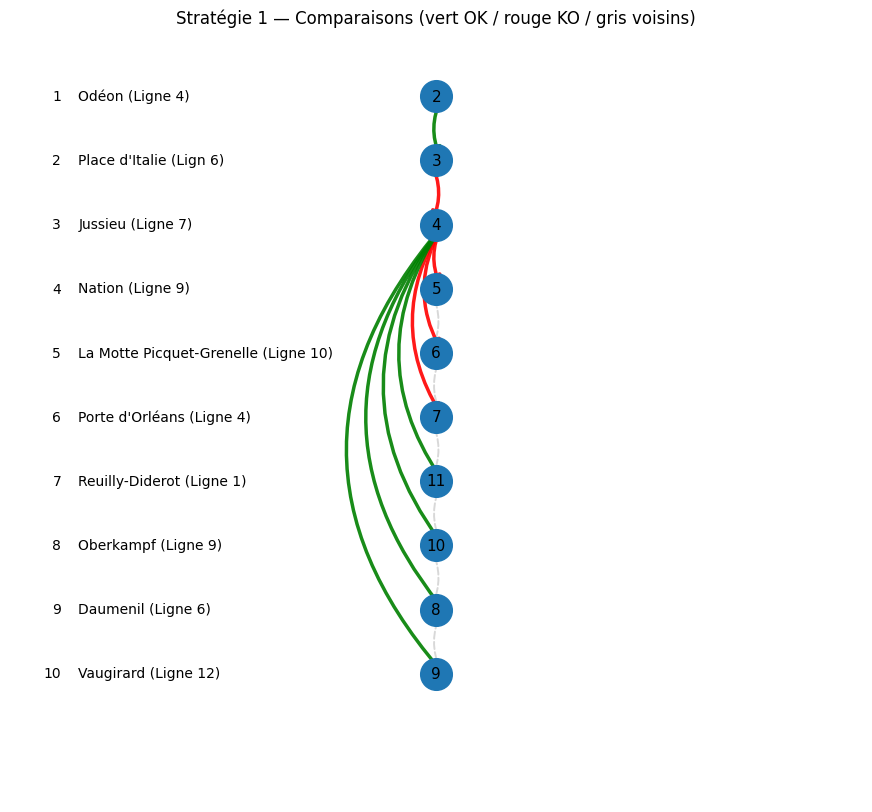

In [37]:
strategy1_results = run_strategy_1(
    sorted_dataset=stations_ranked,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False
)

plot_strategy_graph(station_name_map=station_name_map,
    stations_ranked=stations_ranked,
    results=strategy1_results,
    title="Stratégie 1 — Comparaisons (vert OK / rouge KO / gris voisins)",
    show_gray_neighbors=True,
    alternate_sides=True
)


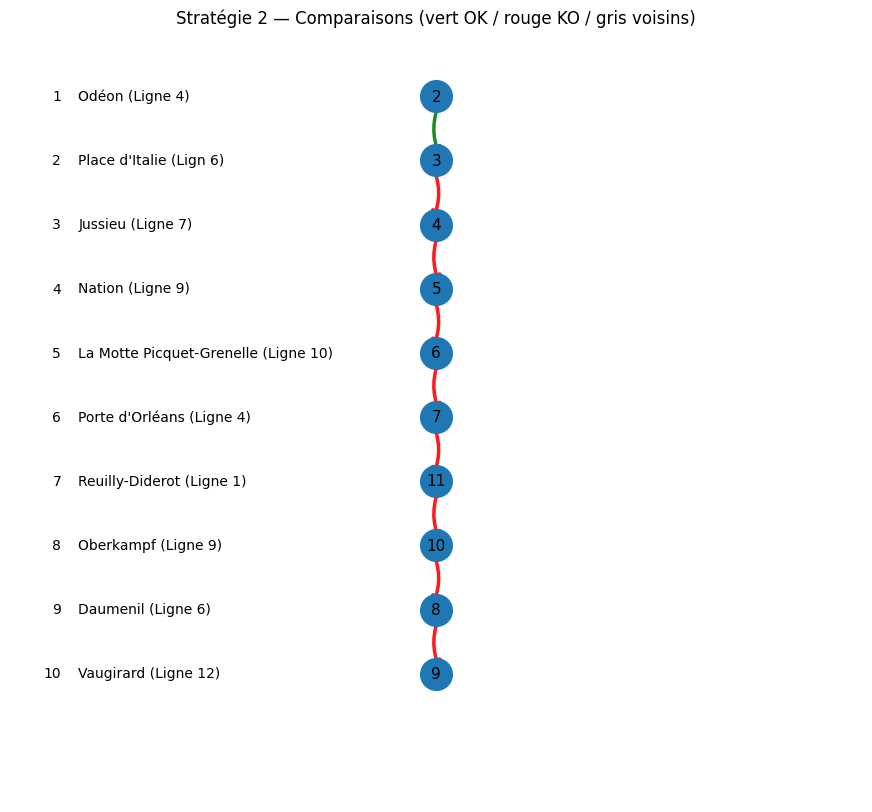

In [38]:
strategy2_results = run_strategy_2(eps_zero=0.0, gurobi_output=False)

plot_strategy_graph(station_name_map=station_name_map,
    stations_ranked=stations_ranked,
    results=strategy2_results,
    title="Stratégie 2 — Comparaisons (vert OK / rouge KO / gris voisins)",
    show_gray_neighbors=True,
    alternate_sides=True
)


[ordre top-k] Comparaison: 2 ≻ 3
[ordre top-k] Comparaison: 3 ≻ 4
[seuil] Comparaison: 4 ≻ 5
[echec] Aucun candidat entre le seuil (rang 3) et 5 ne marche.
[seuil] Comparaison: 4 ≻ 6
[descend via rang 4] Comparaison: 5 ≻ 6
[echec] Aucun candidat entre le seuil (rang 3) et 6 ne marche.
[seuil] Comparaison: 4 ≻ 7
[descend via rang 4] Comparaison: 5 ≻ 7
[descend via rang 5] Comparaison: 6 ≻ 7
[echec] Aucun candidat entre le seuil (rang 3) et 7 ne marche.
[seuil] Comparaison: 4 ≻ 11
[seuil] Comparaison: 4 ≻ 10
[seuil] Comparaison: 4 ≻ 8
[seuil] Comparaison: 4 ≻ 9


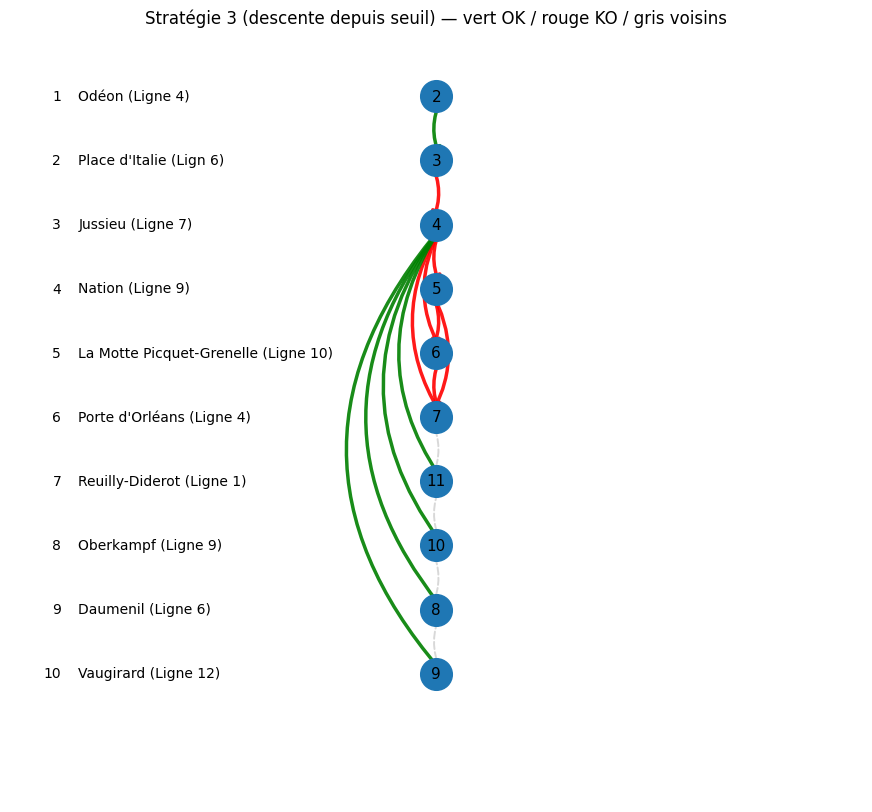

In [46]:
strategy3d_results, connected_rest, not_connected_rest = run_strategy_3_descend_from_threshold(
    sorted_dataset=stations_ranked,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True
)

plot_strategy_graph(
    stations_ranked=stations_ranked,
    results=strategy3d_results,
    station_name_map=station_name_map,
    title="Stratégie 3 (descente depuis seuil) — vert OK / rouge KO / gris voisins",
    show_gray_neighbors=True,
    alternate_sides=True
)
